<a href="https://colab.research.google.com/github/dnrghks5583/Way-that-set-threshold-for-setting-PMD/blob/main/CIFAR_100_resnet56.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input
from tensorflow.keras.layers import Flatten, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
import numpy as np
import os
import math
import tensorflow as tf

# training parameters
batch_size = 32 # orig paper trained all networks with batch_size=128
epochs = 100
num_classes = 100
data_augmentation = True

# subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 9

# model version
# orig paper: version = 1 (ResNet v1), 
# improved ResNet: version = 2 (ResNet v2)
version = 1
path = '/content/gdrive/My Drive/caltech101_pickle'
image_size = (32, 32)
input_shape = (32, 32, 3)
num_classes = 100

In [3]:
# load the CIFAR100 data
from tensorflow.keras.datasets import cifar100
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

169017344/169001437 [==============================] - 2s 0us/step


In [4]:
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# input image dimensions.
input_shape = x_train.shape[1:]

# normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# if subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('Model_Type : ' , model_type)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

Model_Type :  ResNet56v1
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [5]:
model_path = '/content/gdrive/My Drive/cifar100/CIFAR-100_ResNet56v1_model.125.h5'
model = tf.keras.models.load_model(model_path) # load model

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [7]:
y_pred = model.predict(x_test)
model.evaluate(x_test, y_test)

313/313 [==============================] - 9s 24ms/step - loss: 1.6735 - acc: 0.6983


[1.6734702587127686, 0.6983000040054321]

In [8]:
print(y_pred)

[[2.2826840e-09 4.2254212e-12 3.8028073e-05 ... 1.8223121e-08
  2.3246917e-05 5.9728869e-08]
 [1.0234086e-08 4.9161621e-08 1.7898856e-07 ... 9.5345604e-05
  2.0154322e-07 8.9976417e-09]
 [6.1935901e-11 7.7318205e-09 9.4739882e-08 ... 6.9706108e-09
  6.3515266e-08 5.9239649e-09]
 ...
 [2.2907141e-09 6.6338779e-09 9.0769861e-13 ... 4.5121201e-10
  5.1505461e-14 2.1368558e-08]
 [5.7627231e-17 2.7721918e-14 1.8187761e-14 ... 2.0939958e-06
  3.8494425e-12 2.4129619e-08]
 [4.2458911e-08 2.7441472e-06 3.2265616e-05 ... 3.3930393e-11
  3.0575084e-05 3.0457042e-07]]


In [9]:
print(sum(y_pred[50]))

1.0000000423474997


In [10]:
import tensorflow

cce = tensorflow.keras.losses.categorical_crossentropy(
    y_test,
    y_pred,
    from_logits = False,
    label_smoothing = 0)
cce = cce.numpy()
print(cce)

[6.4812961e+00 2.8651167e-02 6.5820475e+00 ... 6.4373226e-06 2.8256595e-04
 2.9145181e-01]


In [11]:
def classification_Cce(cce, y_test, y_pred) :
  c = []
  m = []
  c_i = []

  for i in range(len(y_test)) :
    if np.argmax(y_test[i]) == np.argmax(y_pred[i]) :
      c.append(cce[i])
      c_i.append(i)
    else :
      m.append(cce[i])

  return c, m, c_i

In [12]:
collect_Cce, missclassification_Cce, collect_Idx = classification_Cce(cce, y_test, y_pred)
print(len(collect_Cce))
print(len(missclassification_Cce))

6983
3017


In [13]:
import matplotlib.pyplot as plt

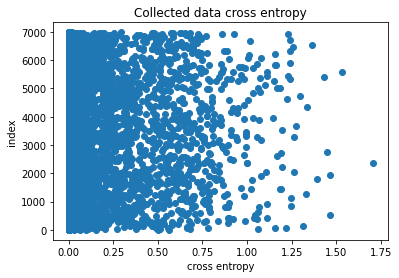

In [14]:
x_value = []
for i in range(len(collect_Cce)) :
  x_value.append(i)

plt.scatter(collect_Cce, x_value)
plt.title('Collected data cross entropy')
plt.ylabel('index')
plt.xlabel('cross entropy')
plt.show()

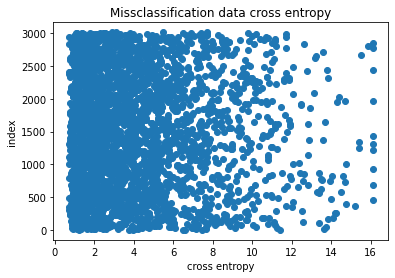

In [15]:
X_value = []
for i in range(len(missclassification_Cce)) :
  X_value.append(i)

plt.scatter(missclassification_Cce, X_value)
plt.title('Missclassification data cross entropy')
plt.ylabel('index')
plt.xlabel('cross entropy')
plt.show()

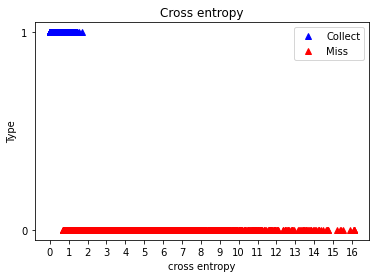

In [16]:
Y = []
for i in range(len(collect_Cce)) :
  Y.append(1)
y = []
for i in range(len(missclassification_Cce)) :
  y.append(0)

values = [0, 1, 2, 3, 4, 5, 6, 7, 8 ,9, 10, 11, 12 ,13, 14, 15, 16]

plt.plot(collect_Cce, Y, 'b^', missclassification_Cce, y, 'r^')
plt.title('Cross entropy')
plt.ylabel('Type')
plt.xlabel('cross entropy')
plt.legend(['Collect', 'Miss'])
plt.yticks([1,0])
plt.xticks(values)

plt.show()

In [17]:
print(max(collect_Cce))
print(min(missclassification_Cce))

1.7059131
0.70325565


In [18]:
cnt = 0

for i in collect_Cce : 
  if i < 0.0001 :
    cnt = cnt + 1
print(cnt)
print(cnt/len(collect_Cce))

1527
0.21867392238292999


In [19]:
def static_Threshold() :
  threshold = [0.0000001, 0.000001, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
  return threshold

In [20]:
staticThreshold = static_Threshold()
print(staticThreshold)

[1e-07, 1e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]


In [21]:
n_cce = cce/max(cce)

In [22]:
def dynamic_Threshold(cce) :
  #Z = [1.96, 2.17, 2.576] # 95%, 97%, 99% two-tails
  Z = [2.326, 1.96, 1.645] # 95%, 97.5%, 99% one-tails
  threshold = []
  x_ = np.mean(cce)
  o = np.std(cce)
  n = len(cce) **(1/2)
  print(x_)
  print(o)
  print(n)
  for z in Z :
    threshold.append(x_- (z * o)/n)

  return threshold

In [23]:
dynamicThreshold = dynamic_Threshold(n_cce)
dynamicThreshold.append(min(missclassification_Cce))
print(dynamicThreshold)

0.08350911
0.15477048
100.0
[0.07990914858192205, 0.08047560853362083, 0.08096313554123044, 0.70325565]


In [24]:
def detection(threshold, cce, collect) : 
  PMD = []
  for i in collect :
    if cce[i] > threshold :
        PMD.append(i)
  return PMD

In [25]:
def detection_PMD(list_of_threshold, cce, collect):
  PMD_by_threshold = []

  for th in list_of_threshold :
    PMD_by_threshold.append(detection(th, cce, collect))
  return PMD_by_threshold

In [26]:
PMD_By_Static_Threshold  = detection_PMD(staticThreshold, cce, collect_Idx)
PMD_By_Dynamic_Threshold = detection_PMD(dynamicThreshold, cce, collect_Idx)

In [27]:
for i in range(len(PMD_By_Static_Threshold)) :
  print(staticThreshold[i], len(PMD_By_Static_Threshold[i]))

for i in range(len(PMD_By_Dynamic_Threshold)) :
  print(dynamicThreshold[i], len(PMD_By_Dynamic_Threshold[i]))

1e-07 6983
1e-06 6550
1e-05 6119
5e-05 5697
0.0001 5456
0.0005 4838
0.001 4507
0.01 3216
0.05 2155
0.1 1700
0.2 1212
0.3 919
0.4 703
0.5 551
0.07990914858192205 1851
0.08047560853362083 1847
0.08096313554123044 1839
0.70325565 247


In [28]:
import cv2

In [29]:
def rotate_img_set(data_set, angle) : # 10' ~ 90'
  rotated_img = []
  print("rotate " + str(angle) + "degree")
  for img in data_set :
    m = cv2.getRotationMatrix2D((16, 16), angle, 1)
    new_img = cv2.warpAffine(img, m, (32, 32), cv2.INTER_AREA, borderMode = 1)
    rotated_img.append(new_img)
    
  return rotated_img

In [30]:
def img_trim(img, size) :
  w = 32
  h = 32
  new_img = img[size:size+h, size:size+w]
  return new_img

In [31]:
def size_Adjust(x_test, rate) :

  new_data_set = []
  if rate > 1 : # aggmentation
    print("augmentation " + str(rate) + "%")
    size = round(32*rate/2 - 16)
    for img in x_test :
      new_img = cv2.resize(img, None, fx = rate, fy = rate, interpolation = cv2.INTER_LINEAR)
      new_img = img_trim(new_img, size)
      new_data_set.append(new_img)
  else :  # reduction
    print("reduction " + str(rate) + "%")
    size = round(32 * (1-rate))
    for img in x_test :
      new_img = cv2.resize(img, None, fx = rate, fy = rate, interpolation = cv2.INTER_AREA)
      new_img = np.pad(new_img, ((size, size), (size, size), (0, 0)), mode = 'edge')
      new_img = cv2.resize(new_img, (32, 32), interpolation = cv2.INTER_AREA)
      new_data_set.append(new_img)

  return new_data_set

In [32]:
def get_MD(y_pred, new_y_pred, y_test) :
  MD = []
  for i in range(len(y_pred)) :
    if np.argmax(y_pred[i]) == np.argmax(y_test[i]) and np.argmax(new_y_pred[i]) != np.argmax(y_test[i]) :
      MD.append(i)
  print("    Find MD : " + str(len(MD)))
  return MD

In [33]:
def calc_Acc(new_y_pred, y_test) :
  cnt = 0
  for i in range(len(y_pred)) :
    if np.argmax(new_y_pred[i]) == np.argmax(y_test[i]) :
      cnt = cnt + 1
  acc = cnt/len(y_pred)
  print("  Acc : " + str(acc))

In [34]:
def get_PMD_Precision(MD, PMD) :
  cnt = 0
  if len(PMD) == 0 :
    return 0
  print("        PMD : " + str(len(PMD)))
  print("        MD : " + str(len(MD)))
  for data in PMD : 
    if data in MD :
      cnt = cnt + 1
  precision = cnt/len(PMD)
  print("        Precision : " + str(precision))
  return precision

In [35]:
def get_PMD_Recall(MD, PMD) :
  cnt = 0
  if len(MD) == 0 :
    return 0
  for data in MD : 
    if data in PMD :
      cnt = cnt + 1
  recall = cnt/len(MD)
  print("        Recall : " + str(recall))
  return recall

In [36]:
def get_Result(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, data_set, y_pred, y_test) : #
  Stp = []   # [ th = 0.1_pre1, th = 0.2_pre2, ... , th = 0.9_pre9 ] number of elements = 9
  Dtp = []   # [ th = min_pre1, th = 95%_pre2, ... , th = 99%_pre4 ] number of elements = 4
  Str = []   # [ th = 0.1_rec1, th = 0.2_rec2, ... , th = 0.9_rec9 ] number of elements = 9
  Dtr = []   # [ th = min_rec1, th = 95%_rec2, ... , th = 99%_rec4 ] number of elements = 4
  st = 1
  dt = 1

  new_y_pred = model.predict(data_set)
  calc_Acc(new_y_pred, y_test)
  MD = get_MD(y_pred, new_y_pred, y_test)

  print("      " + "static threshold")
  for s in PMD_By_Static_Threshold :
    print("        " + str(st) + "st static threshold")
    st = st + 1
    Stp.append(get_PMD_Precision(MD, s))
    Str.append(get_PMD_Recall(MD, s))
    print()

  print("      " + "dynamic threshold")
  for d in PMD_By_Dynamic_Threshold :
    print("        " + str(dt) + "st dynamic threshold")
    dt = dt + 1
    Dtp.append(get_PMD_Precision(MD, d))
    Dtr.append(get_PMD_Recall(MD, d))
    print()

  return Stp, Dtp, Str, Dtr

In [37]:
def get_Avg_Result(lists) : #
  x = len(lists[0]) # static = 9, dynamic = 4
  y = len(lists)    # aggmentation, reduction = 4, rotate = 9
  Avg = []

  for i in range(x) :
    temp = 0
    for j in range(y) :
      temp = temp + lists[j][i]
    Avg.append(temp/y)
  return Avg

In [38]:
def validation(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, y_pred, y_test, list_of_rate, rotated = False) : #

  stp_Result = []
  dtp_Result = []
  str_Result = []
  dtr_Result = []

  for rate in list_of_rate :
    if rotated :
      data_set = rotate_img_set(x_test, rate)
    else :
      data_set = size_Adjust(x_test, rate)
    data_set = np.array(data_set)

    Stp, Dtp, Str, Dtr = get_Result(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, data_set, y_pred, y_test)
    stp_Result.append(Stp)
    dtp_Result.append(Dtp)
    str_Result.append(Str)
    dtr_Result.append(Dtr)

  stp_Result = get_Avg_Result(stp_Result)
  dtp_Result = get_Avg_Result(dtp_Result)
  str_Result = get_Avg_Result(str_Result)
  dtr_Result = get_Avg_Result(dtr_Result)
  return stp_Result, dtp_Result, str_Result, dtr_Result

In [39]:
def print_Result(stp_Result, dtp_Result, str_Result, dtr_Result, comments, staticThreshold, dynamicThreshold) :
  print(comments)
  print(staticThreshold)
  print(stp_Result)
  print(str_Result)
  print(dynamicThreshold)
  print(dtp_Result)
  print(dtr_Result)

In [40]:
list_of_ag_rate = [1.1, 1.2, 1.3, 1.4]
list_of_rd_rate = [0.9, 0.8, 0.7, 0.6]
list_of_degree = [10, 20, 30, 40, 50, 60 ,70, 80 ,90]

In [41]:
rot_Stp, rot_Dtp, rot_Str, rot_Dtr = validation(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, y_pred, y_test, list_of_degree, True)   ## rotated

rotate 10degree
  Acc : 0.6622
    Find MD : 903
      static threshold
        1st static threshold
        PMD : 6983
        MD : 903
        Precision : 0.12931404840326507
        Recall : 1.0

        2st static threshold
        PMD : 6550
        MD : 903
        Precision : 0.13770992366412213
        Recall : 0.9988925802879292

        3st static threshold
        PMD : 6119
        MD : 903
        Precision : 0.14740970746854062
        Recall : 0.9988925802879292

        4st static threshold
        PMD : 5697
        MD : 903
        Precision : 0.15745129015271195
        Recall : 0.9933554817275747

        5st static threshold
        PMD : 5456
        MD : 903
        Precision : 0.16367302052785923
        Recall : 0.9889258028792912

        6st static threshold
        PMD : 4838
        MD : 903
        Precision : 0.18272013228606862
        Recall : 0.9789590254706534

        7st static threshold
        PMD : 4507
        MD : 903
        Precision : 0.1943

In [42]:
ag_Stp, ag_Dtp, ag_Str, ag_Dtr = validation(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, y_pred, y_test, list_of_ag_rate, False)    ## augmentation

augmentation 1.1%
  Acc : 0.6783
    Find MD : 804
      static threshold
        1st static threshold
        PMD : 6983
        MD : 804
        Precision : 0.11513676070456824
        Recall : 1.0

        2st static threshold
        PMD : 6550
        MD : 804
        Precision : 0.12274809160305343
        Recall : 1.0

        3st static threshold
        PMD : 6119
        MD : 804
        Precision : 0.13139401863049519
        Recall : 1.0

        4st static threshold
        PMD : 5697
        MD : 804
        Precision : 0.14112690889942076
        Recall : 1.0

        5st static threshold
        PMD : 5456
        MD : 804
        Precision : 0.14736070381231672
        Recall : 1.0

        6st static threshold
        PMD : 4838
        MD : 804
        Precision : 0.16515088879702355
        Recall : 0.9937810945273632

        7st static threshold
        PMD : 4507
        MD : 804
        Precision : 0.1763922786776126
        Recall : 0.9888059701492538

        

In [43]:
rd_Stp, rd_Dtp, rd_Str, rd_Dtr = validation(PMD_By_Static_Threshold, PMD_By_Dynamic_Threshold, y_pred, y_test, list_of_rd_rate, False)   ## reduction

reduction 0.9%
  Acc : 0.6485
    Find MD : 1144
      static threshold
        1st static threshold
        PMD : 6983
        MD : 1144
        Precision : 0.16382643562938565
        Recall : 1.0

        2st static threshold
        PMD : 6550
        MD : 1144
        Precision : 0.17465648854961832
        Recall : 1.0

        3st static threshold
        PMD : 6119
        MD : 1144
        Precision : 0.1864683771858147
        Recall : 0.9973776223776224

        4st static threshold
        PMD : 5697
        MD : 1144
        Precision : 0.19922766368264
        Recall : 0.9921328671328671

        5st static threshold
        PMD : 5456
        MD : 1144
        Precision : 0.20674486803519063
        Recall : 0.986013986013986

        6st static threshold
        PMD : 4838
        MD : 1144
        Precision : 0.23046713517982637
        Recall : 0.9746503496503497

        7st static threshold
        PMD : 4507
        MD : 1144
        Precision : 0.24339915686709562

In [44]:
print_Result(rot_Stp, rot_Dtp, rot_Str, rot_Dtr, "Rotation", staticThreshold, dynamicThreshold)

Rotation
[1e-07, 1e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
[0.5461835887154518, 0.5597455470737913, 0.5684116867316737, 0.5781795486903438, 0.5837813620071685, 0.5945983188645445, 0.6021990483938565, 0.6332573244886678, 0.663057489043568, 0.6832679738562092, 0.7029702970297029, 0.7161165518075204, 0.7321005215742058, 0.7420850978019762]
[1.0, 0.966225531819646, 0.9228361647568817, 0.8794891903644544, 0.85358597113888, 0.7802317181157495, 0.7410858608789475, 0.5729081453730461, 0.41636285678490037, 0.3437550378096134, 0.2579395411459513, 0.20175675901282833, 0.15940720931271615, 0.1274703373777909]
[0.07990914858192205, 0.08047560853362083, 0.08096313554123044, 0.70325565]
[0.677651719791104, 0.6771942489322024, 0.6768171107485953, 0.7638326585695007]
[0.3690503739423471, 0.36790204897285, 0.3662341347407551, 0.059861347099222556]


In [45]:
print_Result(ag_Stp, ag_Dtp, ag_Str, ag_Dtr, "Augmentation", staticThreshold, dynamicThreshold)

Augmentation
[1e-07, 1e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
[0.22203923814979235, 0.23400763358778626, 0.24595522144141202, 0.2584254870984729, 0.26622067448680353, 0.2872054568003307, 0.29914577324162417, 0.3547885572139304, 0.40997679814385146, 0.4427941176470588, 0.4738036303630363, 0.5021762785636561, 0.5245376955903271, 0.5313067150635209]
[1.0, 0.9919447220350802, 0.9787393752062172, 0.9620078894673703, 0.9524554023567474, 0.9202000762523119, 0.8977269351680226, 0.7777416436263891, 0.6202727549280236, 0.5352717580417478, 0.41444983579807954, 0.33462418163094193, 0.2688526658783515, 0.21453286134199157]
[0.07990914858192205, 0.08047560853362083, 0.08096313554123044, 0.70325565]
[0.4316585629389519, 0.4312398484028154, 0.4324361065796628, 0.5809716599190283]
[0.5656475936328862, 0.563807839738897, 0.5629414606300324, 0.10566997577320754]


In [46]:
print_Result(rd_Stp, rd_Dtp, rd_Str, rd_Dtr, "Reduction", staticThreshold, dynamicThreshold)

Reduction
[1e-07, 1e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
[0.4933767721609623, 0.507824427480916, 0.5213270142180094, 0.5341846585922415, 0.5418804985337244, 0.5610272840016536, 0.5707787885511426, 0.6116293532338308, 0.6618329466357309, 0.6791176470588235, 0.7085396039603961, 0.7252448313384113, 0.7400426742532006, 0.7509074410163339]
[1.0, 0.9761241881964441, 0.947449622363121, 0.9152504228775076, 0.8951022411250374, 0.8387741528056623, 0.8040592833933455, 0.6439393026247214, 0.4902542490770133, 0.40358881490051945, 0.3065080511906106, 0.2422619073508741, 0.1918883834541412, 0.15467010486559432]
[0.07990914858192205, 0.08047560853362083, 0.08096313554123044, 0.70325565]
[0.6746353322528363, 0.6743367623172712, 0.6741435562805873, 0.7894736842105263]
[0.4340032279134052, 0.43296395763041007, 0.4309786346643805, 0.07434244403717663]
